# End-to-End Predictive Model for Real Estate Prices

## Part 1 Frame the Problem

For this predictive model I will be predicting median house prices in California districts. I will use features such as median income and geographical location to help predict prices.  
This is a supervised learning model as I have the median house prices (target label) already. I will use root mean squre error and R2 to measure the performance of the models I build. I will build multiple models such as linear regression, decision tree regressor, SVM, random forest regressor and more.

## Part 2 Import the data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Part 3 Explore Data to gain insights

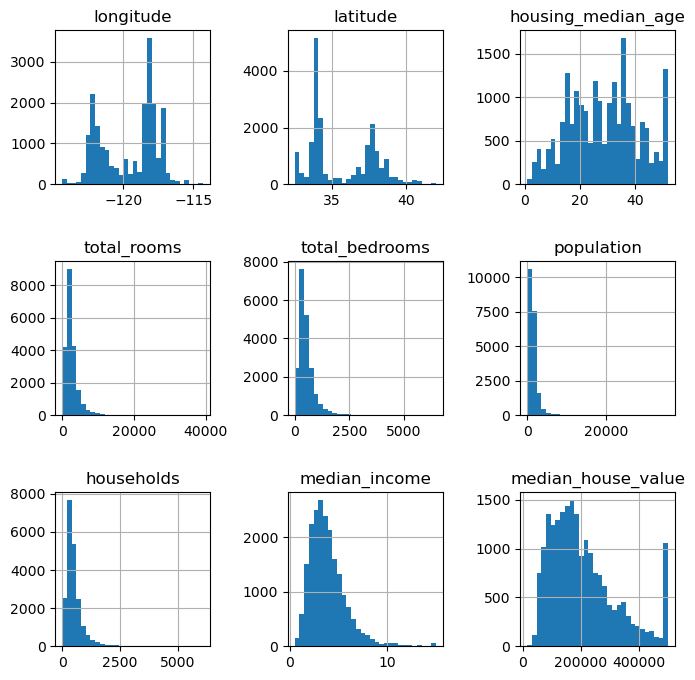

In [2]:
#get histogram plots of all data
import matplotlib.pyplot as plt

data.hist(bins=30,figsize=(8,8))
plt.subplots_adjust(hspace=0.5, wspace=0.5);  

Most of the data is right skew and median_house_value and housing_median_age has huge spikes at the end. This indicates they have capped pricing and age. While this prevents outliers it skews data analysis. The best way to fix this is to create groups for age. Also later I will standarise data to fix the right skewness. 

In [3]:
#get a summary of data to know how to cut 
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
#create a copy of data and create classes for median age
group = data.copy()
group['age_cat']=pd.cut(group['housing_median_age'], bins=[0,18,29,37,50,np.inf],
                          labels = [1,2,3,4,5])

<Axes: xlabel='age_cat'>

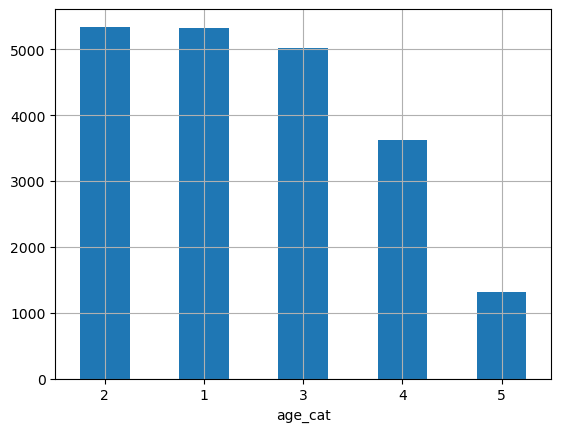

In [5]:
#plot new age group value counts
group['age_cat'].value_counts().plot.bar(rot=0,grid=True)

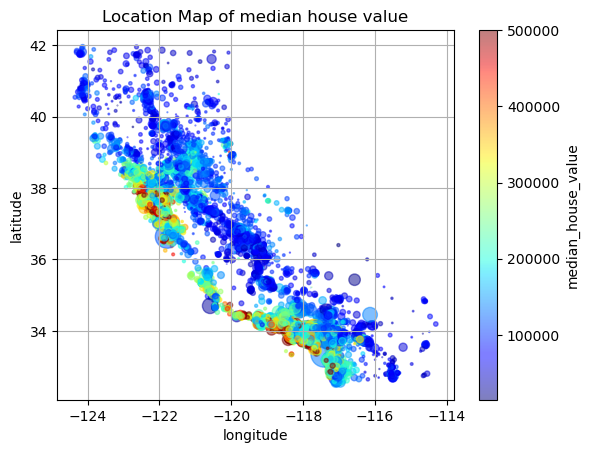

In [6]:
#plot a location scatter plot
group.plot(kind='scatter',x='longitude',y='latitude', alpha=0.5,
           s=group.population/100, c='median_house_value', cmap='jet',
           colorbar=True, legend=True, title='Location Map of median house value',
          grid=True);

The scatterplot inidcates which areas have higher price houses, which seem to be around the ocean as expected. These seem to be specific clusters as well.

In [7]:
#lets examine correlation and see which are related to median house value the most
corr_df = group.drop('ocean_proximity', axis =1) #can't have objects
corr_df.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
age_cat               0.111061
Name: median_house_value, dtype: float64

As expected median_income by far is the most related. THe others are all poorly correlated. Lets see if I can feature engineer some better attributes.

In [8]:
#from scatter it seems ocean plays an important role, lets view the categories
group.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

This is non-ordinal data the ocean categories don't follow a specific ranking system. So I will use one hot encoder.

In [9]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
group_ohe = ohe.fit_transform(group[['ocean_proximity']])

In [10]:
group_ohe

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [11]:
ohe.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [12]:
#create DF of one hot encoder
group_cat = pd.DataFrame(group_ohe, columns=ohe.categories_,
                         index = group.index)
group_cat.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [13]:
#merge group_cat with group minus original ocean
group2 = pd.concat([group,group_cat],axis=1).drop('ocean_proximity',axis=1)

In [14]:
group2.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,age_cat,"(<1H OCEAN,)","(INLAND,)","(ISLAND,)","(NEAR BAY,)","(NEAR OCEAN,)"
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,4,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,2,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,5,0.0,0.0,0.0,1.0,0.0


In [15]:
group2.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
age_cat               0.111061
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
Name: median_house_value, dtype: float64

The ocean proximity encoded features are more correlated than most others as expected.

Currently latitude and longitude have low correlation, I will create cluster centres using KMeans to see if it improves correlation

In [16]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 10, random_state=42)
group2['clusters'] = km.fit_predict(group[['latitude','longitude']])

C:\Users\natha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
cc = km.cluster_centers_
cc

array([[  38.24584324, -121.1646    ],
       [  34.87846723, -119.63089852],
       [  34.00083736, -118.20949841],
       [  37.94272958, -122.3289482 ],
       [  36.64991581, -119.65117867],
       [  32.89754686, -116.95712238],
       [  37.23943733, -121.91252368],
       [  40.52711165, -123.20058252],
       [  34.00382501, -117.36458777],
       [  39.51662692, -121.33221465]])

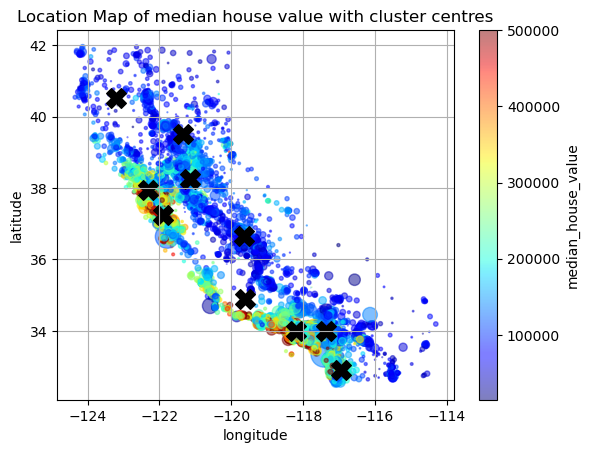

In [18]:
#visual cluster centres
#plot a location scatter plot
group.plot(kind='scatter',x='longitude',y='latitude', alpha=0.5,
           s=group.population/100, c='median_house_value', cmap='jet',
           colorbar=True, legend=True, title='Location Map of median house value with cluster centres',
          grid=True);
plt.scatter(cc[:,1],cc[:,0], marker='X', s=200, c='black');

In [19]:
#examine new correlation
group2.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
age_cat               0.111061
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
clusters             -0.094779
Name: median_house_value, dtype: float64

The clusters hasn't impoved correlation, just averaged long and lat. I will examine rooms and bedrooms per house instead of total.

In [20]:
group2['rooms_per_house']=group2['total_rooms']/group2['households']
group2['bedrooms_per_house']=group2['total_bedrooms']/group2['households']
group2['bedrooms_ratio']=group2['total_bedrooms']/group2['total_rooms']
group2['ppl_per_house']=group2['population']/group2['households']
group2.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
age_cat               0.111061
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
clusters             -0.094779
rooms_per_house       0.151948
bedrooms_per_house   -0.046739
bedrooms_ratio       -0.255880
ppl_per_house        -0.023737
Name: median_house_value, dtype: float64

Only bedrooms_ratio has created a new variable with a decent correlation increase.

In [21]:
#to standardise data will need to remove ocean ohe categories
group2.columns

Index([         'longitude',           'latitude', 'housing_median_age',
              'total_rooms',     'total_bedrooms',         'population',
               'households',      'median_income', 'median_house_value',
                  'age_cat',       ('<1H OCEAN',),          ('INLAND',),
                ('ISLAND',),        ('NEAR BAY',),      ('NEAR OCEAN',),
                 'clusters',    'rooms_per_house', 'bedrooms_per_house',
           'bedrooms_ratio',      'ppl_per_house'],
      dtype='object')

In [22]:
group3 = group2.drop([('<1H OCEAN',),          ('INLAND',),
                ('ISLAND',),        ('NEAR BAY',),      ('NEAR OCEAN',)],axis=1)

In [23]:
#lets standardise data and measure correlation
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
group_ss = ss.fit_transform(group3)

In [24]:
#turn back into pd
group4 = pd.DataFrame(group_ss, columns = group3.columns, index=group3.index)
#merge back with group_ohe
group5 = pd.concat([group4,group_cat],axis=1)
group5.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,age_cat,clusters,rooms_per_house,bedrooms_per_house,bedrooms_ratio,ppl_per_house,"(<1H OCEAN,)","(INLAND,)","(ISLAND,)","(NEAR BAY,)","(NEAR OCEAN,)"
0,-1.327835,1.052548,0.982143,-0.804819,-0.970325,-0.974429,-0.977033,2.344766,2.129631,1.201189,-0.190572,0.628559,-0.153863,-1.146024,-0.049597,0.0,0.0,0.0,1.0,0.0
1,-1.322844,1.043185,-0.607019,2.045890,1.348276,0.861439,1.669961,2.332238,1.314156,-0.431564,-0.190572,0.327041,-0.262936,-0.987254,-0.092512,0.0,0.0,0.0,1.0,0.0
2,-1.332827,1.038503,1.856182,-0.535746,-0.825561,-0.820777,-0.843637,1.782699,1.258693,2.017566,-0.190572,1.155620,-0.049604,-1.440514,-0.025843,0.0,0.0,0.0,1.0,0.0
3,-1.337818,1.038503,1.856182,-0.624215,-0.718768,-0.766028,-0.733781,0.932968,1.165100,2.017566,-0.190572,0.156966,-0.050417,-0.492925,-0.050329,0.0,0.0,0.0,1.0,0.0
4,-1.337818,1.038503,1.856182,-0.462404,-0.611974,-0.759847,-0.629157,-0.012881,1.172900,2.017566,-0.190572,0.344711,-0.033568,-0.706141,-0.085616,0.0,0.0,0.0,1.0,0.0


In [25]:
#meaure correlation now
group5.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
age_cat               0.111061
clusters             -0.094779
rooms_per_house       0.151948
bedrooms_per_house   -0.046739
bedrooms_ratio       -0.255880
ppl_per_house        -0.023737
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
Name: median_house_value, dtype: float64

In [26]:
#lets remove redundant columns
group5 = group5.drop(['total_rooms','bedrooms_per_house', 'ppl_per_house', 
                      'clusters','housing_median_age'],axis=1)
group5.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
age_cat               0.111061
rooms_per_house       0.151948
bedrooms_ratio       -0.255880
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
Name: median_house_value, dtype: float64

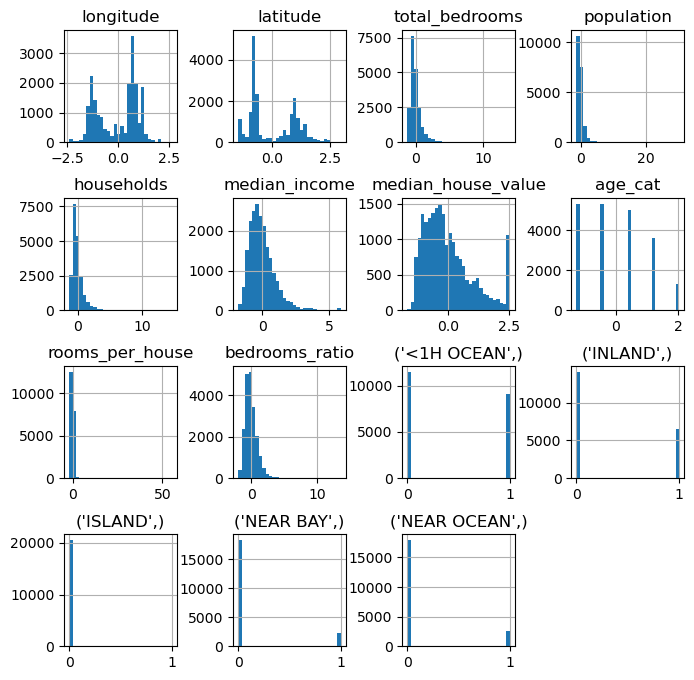

In [27]:
#visualise shape
group5.hist(bins=30, figsize=(8,8))
plt.subplots_adjust(hspace=0.5, wspace=0.5);  

Can see standardising data hasn't fixed skewed shape, I will try using a log transformation before standardising.

In [28]:
group3.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,age_cat,clusters,rooms_per_house,bedrooms_per_house,bedrooms_ratio,ppl_per_house
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,4,3,6.984127,1.023810,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,2,3,6.238137,0.971880,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5,3,8.288136,1.073446,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5,3,5.817352,1.073059,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,5,3,6.281853,1.081081,0.172096,2.181467


In [29]:
#use log transformer
from sklearn.preprocessing import FunctionTransformer
#log the skewed distributions
group6 = group3[['total_bedrooms','population','households','median_income',
                 'rooms_per_house','bedrooms_ratio']]
log_ft = FunctionTransformer(func=np.log,inverse_func = np.exp)
log_group6 = log_ft.fit_transform(group6)

In [30]:
log_group6.head()

,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio
0,4.859812,5.774552,4.836282,2.119287,1.943640,-1.920110
1,7.008505,7.783641,7.037028,2.116424,1.830682,-1.859204
2,5.247024,6.206576,5.176150,1.982022,2.114825,-2.043951
3,5.459586,6.324359,5.389072,1.730434,1.760845,-1.690331
4,5.634790,6.336826,5.556828,1.347086,1.837665,-1.759704


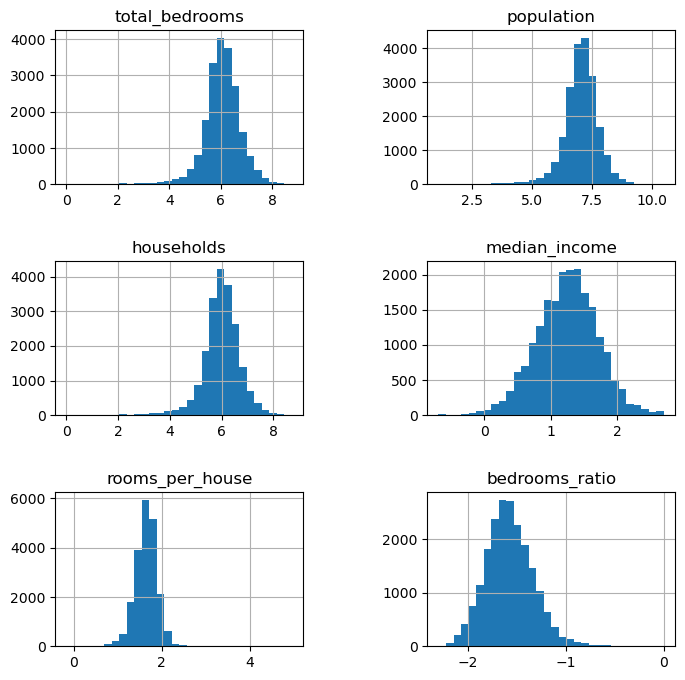

In [31]:
#visualise shape
log_group6.hist(bins=30, figsize=(8,8))
plt.subplots_adjust(hspace=0.5, wspace=0.5);  

log transformation has gotten rid of the right skew.

In [32]:
#take out the log transformed columns with original values

group7 = group3.drop(['total_bedrooms','population','households','median_income',
                 'rooms_per_house','bedrooms_ratio'],axis=1)

In [33]:
#combine the log values
group7_log = pd.concat([group7,log_group6],axis=1)

In [34]:
#examine correlation now
group7_log.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
median_house_value    1.000000
age_cat               0.111061
clusters             -0.094779
bedrooms_per_house   -0.046739
ppl_per_house        -0.023737
total_bedrooms        0.052926
population           -0.021158
households            0.073175
median_income         0.651807
rooms_per_house       0.240386
bedrooms_ratio       -0.328271
Name: median_house_value, dtype: float64

In [35]:
#lets remove redundant columns from group7_log
group7_log = group7_log.drop(['total_rooms','bedrooms_per_house', 'ppl_per_house', 
                      'housing_median_age'],axis=1)
#add back in ocean ohe
group7_log = pd.concat([group7_log, group_cat],axis=1)
group7_log.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
median_house_value    1.000000
age_cat               0.111061
clusters             -0.094779
total_bedrooms        0.052926
population           -0.021158
households            0.073175
median_income         0.651807
rooms_per_house       0.240386
bedrooms_ratio       -0.328271
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
Name: median_house_value, dtype: float64

In [36]:
#compare with pre log corr
group5.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
age_cat               0.111061
rooms_per_house       0.151948
bedrooms_ratio       -0.255880
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
Name: median_house_value, dtype: float64

It seems the log transorformation was able to increase correlation significantly for rooms_per_household, bedrooms_ratio

In [37]:
#examine group7_log to see if model is ready to start training
group7_log.describe()

,longitude,latitude,median_house_value,clusters,total_bedrooms,population,households,median_income,rooms_per_house,bedrooms_ratio,"(<1H OCEAN,)","(INLAND,)","(ISLAND,)","(NEAR BAY,)","(NEAR OCEAN,)"
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,206855.816909,3.459690,6.051063,7.024116,5.980806,1.244465,1.647771,-1.577678,0.442636,0.317393,0.000242,0.110950,0.128779
std,2.003532,2.135952,115395.615874,2.412221,0.732785,0.738524,0.733071,0.470653,0.274652,0.244423,0.496710,0.465473,0.015563,0.314077,0.334963
min,-124.350000,32.540000,14999.000000,0.000000,0.000000,1.098612,0.000000,-0.693347,-0.167054,-2.302585,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,119600.000000,2.000000,5.690359,6.668228,5.634790,0.941334,1.490816,-1.740530,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,179700.000000,3.000000,6.075346,7.061334,6.013715,1.262657,1.654245,-1.593749,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.710000,264725.000000,5.000000,6.472346,7.452982,6.405228,1.556723,1.800452,-1.427864,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,500001.000000,9.000000,8.771060,10.482402,8.713089,2.708057,4.955187,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


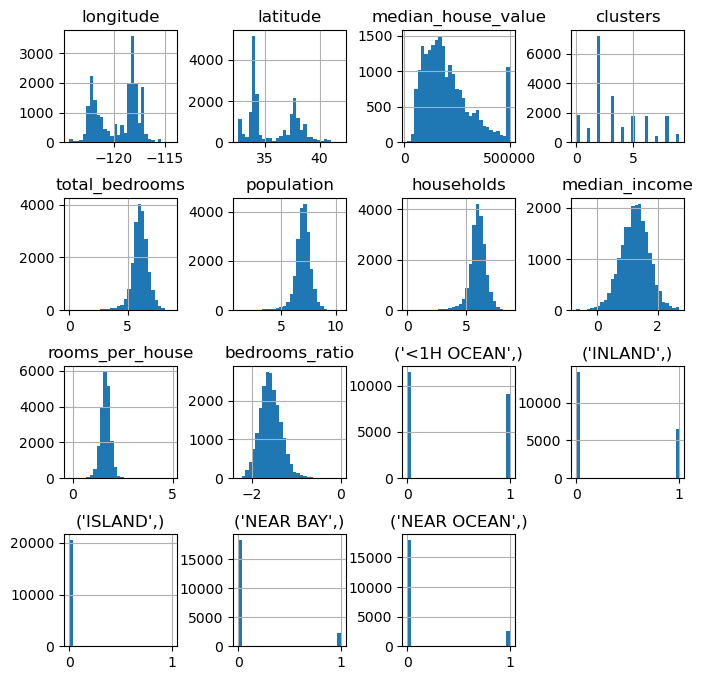

In [38]:
#visualise shape
group7_log.hist(bins=30, figsize=(8,8))
plt.subplots_adjust(hspace=0.5, wspace=0.5);  

from the descibre feature I can see some missing value in bedroom. I will use a simple imputer to replace nulls with median now that data is smoothed out. 

In [39]:
from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy='median')

#filter out only missing entry columns for imputer
group_missing = group7_log[group7_log.columns[group7_log.isna().any()]]
#apply imputer
x = si.fit_transform(group_missing)

In [40]:
group_imp = pd.DataFrame(x, columns = group_missing.columns,
                         index = group_missing.index)
group_imp.head()

,total_bedrooms,bedrooms_ratio
0,4.859812,-1.920110
1,7.008505,-1.859204
2,5.247024,-2.043951
3,5.459586,-1.690331
4,5.634790,-1.759704


In [41]:
#update imputer columns in final model
final = group7_log.copy().drop('clusters',axis=1)
final[['total_bedrooms','bedrooms_ratio']]=group_imp

In [42]:
#check final model has no NA's
final.isna().sum()

longitude             0
latitude              0
median_house_value    0
age_cat               0
total_bedrooms        0
population            0
households            0
median_income         0
rooms_per_house       0
bedrooms_ratio        0
(<1H OCEAN,)          0
(INLAND,)             0
(ISLAND,)             0
(NEAR BAY,)           0
(NEAR OCEAN,)         0
dtype: int64

In [43]:
final.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
median_house_value    1.000000
age_cat               0.111061
total_bedrooms        0.052675
population           -0.021158
households            0.073175
median_income         0.651807
rooms_per_house       0.240386
bedrooms_ratio       -0.326722
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
Name: median_house_value, dtype: float64

In [44]:
#compare with original correlations
group2.corr().median_house_value

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
age_cat               0.111061
(<1H OCEAN,)          0.256617
(INLAND,)            -0.484859
(ISLAND,)             0.023416
(NEAR BAY,)           0.160284
(NEAR OCEAN,)         0.141862
clusters             -0.094779
rooms_per_house       0.151948
bedrooms_per_house   -0.046739
bedrooms_ratio       -0.255880
ppl_per_house        -0.023737
Name: median_house_value, dtype: float64

Can see through feature engineering I have more significant correlations to predict
median house values.

## Feature Engineering Pipeline

I will now create a feature engineering pipeline on train data that performs all transformations done above in one go, allowing me to transform new incoming data instantly. The process is: 
1. convert ocean_proximity using one hot encoder
2. create rooms_per_house and bedroom_ratio columns
3. log transform appropriate columns
4. use simple imputer to replace nulls with median
5. standardise data

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

#create a function to create ratios and age_cat and drop irrelevant columns
def ratio(X):
    X['rooms_per_house']=X['total_rooms']/X['households']
    X['bedrooms_ratio']=X['total_bedrooms']/X['total_rooms']
    X['age_cat']=pd.cut(X['housing_median_age'], bins=[0,18,29,37,50,np.inf],
                          labels = [1,2,3,4,5])
    return X.drop(['total_rooms','housing_median_age'],axis=1)


#create log pipeline
log_pipeline = make_pipeline(
    FunctionTransformer(np.log,inverse_func=np.exp, feature_names_out="one-to-one"),
    SimpleImputer(strategy='median'),
    StandardScaler()
)

#create cat pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown= 'ignore')
)

#create default pipeline
def_pipeline = make_pipeline(
    StandardScaler()
)

#combine all into one
feat_eng = ColumnTransformer([
    ("log", log_pipeline, ["total_bedrooms","bedrooms_ratio", "rooms_per_house", "population",
                               "households", "median_income"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder = def_pipeline)


In [46]:
pd.DataFrame(feat_eng.fit_transform(ratio(data)),columns = feat_eng.get_feature_names_out(),
             index = ratio(data).index)

,log__total_bedrooms,log__bedrooms_ratio,log__rooms_per_house,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__median_house_value,remainder__age_cat
0,-1.634226,-1.407397,1.077275,-1.692016,-1.561311,1.858786,0.0,0.0,0.0,1.0,0.0,-1.327835,1.052548,2.129631,1.201189
1,1.312871,-1.156957,0.665987,1.028461,1.440853,1.852703,0.0,0.0,0.0,1.0,0.0,-1.322844,1.043185,1.314156,-0.431564
2,-1.103136,-1.916626,1.700570,-1.107018,-1.097678,1.567130,0.0,0.0,0.0,1.0,0.0,-1.332827,1.038503,1.258693,2.017566
3,-0.811591,-0.462560,0.411708,-0.947530,-0.807218,1.032566,0.0,0.0,0.0,1.0,0.0,-1.337818,1.038503,1.165100,2.017566
4,-0.571285,-0.747815,0.691414,-0.930649,-0.578372,0.218044,0.0,0.0,0.0,1.0,0.0,-1.337818,1.038503,1.172900,2.017566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.174260,0.347522,-0.106624,-0.385615,-0.247885,-1.698929,0.0,1.0,0.0,0.0,0.0,-0.758826,1.801647,-1.115804,-0.431564
20636,-1.427361,0.171425,0.592821,-1.556094,-1.697841,-0.649557,0.0,1.0,0.0,0.0,0.0,-0.818722,1.806329,-1.124470,-1.247941
20637,0.182203,0.170756,0.007109,-0.148116,0.122682,-1.516731,0.0,1.0,0.0,0.0,0.0,-0.823713,1.778237,-0.992746,-1.247941
20638,-0.051560,0.259970,0.092805,-0.563455,-0.171521,-1.317404,0.0,1.0,0.0,0.0,0.0,-0.873626,1.778237,-1.058608,-1.247941


It appears the pipeline works, I will now split into training and test sets before building the model. Note in train and test sets I will first separate target feature. I will not be transforming feature.

## Train and Test sets

Since I cut the median house age group I will assume a stratified random split will be more efficient. Lets test this

In [47]:
#first define feature and target sets
y = data['median_house_value']
X = ratio(data).drop('median_house_value',axis=1)

In [48]:
X.head()

,longitude,latitude,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,age_cat
0,-122.23,37.88,129.0,322.0,126.0,8.3252,NEAR BAY,6.984127,0.146591,4
1,-122.22,37.86,1106.0,2401.0,1138.0,8.3014,NEAR BAY,6.238137,0.155797,2
2,-122.24,37.85,190.0,496.0,177.0,7.2574,NEAR BAY,8.288136,0.129516,5
3,-122.25,37.85,235.0,558.0,219.0,5.6431,NEAR BAY,5.817352,0.184458,5
4,-122.25,37.85,280.0,565.0,259.0,3.8462,NEAR BAY,6.281853,0.172096,5


In [49]:
from sklearn.model_selection import train_test_split

#create random split

Xtrain, Xtest = train_test_split(X, test_size=0.2, random_state=42)

#create stratified split

Xtrain_s, Xtest_s = train_test_split(X,test_size=0.2, random_state=42, stratify = X.age_cat)

In [50]:
#compare age_cat columns in both train sets
a = X.age_cat.value_counts()/len(X)
b=Xtrain.age_cat.value_counts()/len(Xtrain)
c= Xtrain_s.age_cat.value_counts()/len(Xtrain_s)
print('X')
print(a)
print('Xtrain')
print(b)
print('Xtrain_s')
print(c)

X
age_cat
2    0.258866
1    0.258043
3    0.243508
4    0.175581
5    0.064002
Name: count, dtype: float64
Xtrain
age_cat
1    0.260901
2    0.256722
3    0.244004
4    0.173934
5    0.064438
Name: count, dtype: float64
Xtrain_s
age_cat
2    0.258842
1    0.258055
3    0.243520
4    0.175569
5    0.064014
Name: count, dtype: float64


I can see the stratified sample has same proportions as X for age_cat so it make sense to use this method for splitting.

In [51]:
#Create final train and test sets
#apply feat eng pipeline on X
X_feat = feat_eng.fit_transform(X)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_feat,y,test_size=0.2, random_state=42,
                                                stratify = X.age_cat)

## Building Models  
I will first test a few different models. The model that performs best I will then do hyperparameter tuning on

### Linear Model

In [52]:
#Build the first model using linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#initial model
lr = LinearRegression()

#fit model
lr_model = lr.fit(Xtrain, ytrain)

#get pred
lr_pred = lr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,lr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, lr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 68770.63
R2 score 0.6379416876015147


RSME means error in house price prediction, 68770.63 is far off. I will need a better model.

### Model 2

In [53]:
#build svm model
from sklearn.svm import SVR

#initial model
svr = SVR(kernel='linear')
svr_model = svr.fit(Xtrain, ytrain)
#get pred
svr_pred = svr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,svr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, svr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 108995.75
R2 score 0.090523003846526


In [54]:
#linear svm performed poorly, try poly
#build svm model
from sklearn.svm import SVR

#initial model
svr = SVR(kernel='poly')
svr_model = svr.fit(Xtrain, ytrain)
#get pred
svr_pred = svr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,svr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, svr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 116352.81
R2 score -0.03639734080693513


In [55]:
#poly performed worse, try rbf
from sklearn.svm import SVR

#initial model
svr = SVR(kernel='rbf')
svr_model = svr.fit(Xtrain, ytrain)
#get pred
svr_pred = svr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,svr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, svr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 116696.0
R2 score -0.04252024816824407


All svm base models performed worse than linear regression base. So svm won't be further explored.

### Model 3

In [56]:
#build decision tree model
from sklearn.tree import DecisionTreeRegressor

#initial model
dtr = DecisionTreeRegressor()
dtr_model = dtr.fit(Xtrain, ytrain)
#get pred
dtr_pred = dtr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,dtr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, dtr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 68509.4
R2 score 0.6406870238213207


Similar results to linear regression

### Model 4

In [57]:
#build KNN model
from sklearn.neighbors import KNeighborsRegressor

#initial model
knn = KNeighborsRegressor()
knn_model = knn.fit(Xtrain, ytrain)
#get pred
knn_pred = knn_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,knn_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, knn_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 60551.72
R2 score 0.7193109032839349


Better performance than others so far.

### Model 5


In [58]:
#build random forest model
from sklearn.ensemble import RandomForestRegressor

#initial model
rfr = RandomForestRegressor()
rfr_model = rfr.fit(Xtrain, ytrain)
#get pred
rfr_pred = rfr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,rfr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, rfr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 47973.64
R2 score 0.8238113736667438


Huge increase in peformance, best so far.

### Model 6

In [59]:
#build MLP model
from sklearn.neural_network import MLPRegressor

#initial model
mlp = MLPRegressor()
mlp_model = mlp.fit(Xtrain, ytrain)
#get pred
mlp_pred = mlp_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,mlp_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, mlp_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 162672.74
R2 score -1.0258258359844108


C:\Users\natha\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Worst performance, will skip MLP.

### Model 7

In [60]:
#build bagging model
from sklearn.ensemble import BaggingRegressor

#initial model
bgr = BaggingRegressor()
bgr_model = bgr.fit(Xtrain, ytrain)
#get pred
bgr_pred = bgr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,bgr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, bgr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 50671.37
R2 score 0.803438775345606


Performed only slightly worse than Random Forest

### Model 8 

In [61]:
#build hist gradient boosting model
from sklearn.ensemble import HistGradientBoostingRegressor

#initial model
gbr = HistGradientBoostingRegressor()
gbr_model = gbr.fit(Xtrain, ytrain)
#get pred
gbr_pred = gbr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,gbr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, gbr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 47219.95
R2 score 0.8293039038427006


This model slilghlty outperformed Random Forest. I will see if stacking will improve.

### Model 9

In [ ]:
#build stacking regressor for 3 best models
from sklearn.ensemble import StackingRegressor

#initial model
estimators = [
    ('rf',rfr),
    ('bg',bgr),
    ('hgb',gbr)
]
stack = StackingRegressor(estimators=estimators,
                          final_estimator = HistGradientBoostingRegressor(random_state=42))

stack_model = stack.fit(Xtrain, ytrain)
#get pred
stack_pred = stack_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,stack_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, stack_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

The stacking gave a slight improvement.

### Model 10

In [63]:
#build voting regressor for 3 best models
from sklearn.ensemble import VotingRegressor

#initial model
estimators = [
    ('rf',rfr),
    ('bg',bgr),
    ('hgb',gbr)
]
vote = VotingRegressor(estimators=estimators, n_jobs=-1)
                          
vote_model = vote.fit(Xtrain, ytrain)
#get pred
vote_pred = vote_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,vote_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, vote_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 46671.96
R2 score 0.8332428088394441


Performed slightly worse than stacking, but not by much.

In [65]:
import xgboost as xgb
xgb = xgb.XGBRegressor(random_state=42)
xgb.fit(Xtrain, ytrain)
#get pred
pred = xgb.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

RMSE 46052.08
R2 score 0.8376429620324733


## Cross Validation

I will perform cross validation on the best performing models

In [ ]:
#use 10 fold cross validation on random forest
from sklearn.model_selection import cross_val_score

rfr_cv = -cross_val_score(rfr, Xtrain, ytrain,
                              scoring ='neg_root_mean_squared_error', cv=10)

In [ ]:
pd.Series(rfr_cv).describe()

Mean rmse is slightly higher than first random forest model on train data. This shows model generalises well with random forest

In [ ]:
#use 10 fold cross validation on bagging
from sklearn.model_selection import cross_val_score

bgr_cv = -cross_val_score(bgr, Xtrain, ytrain,
                              scoring ='neg_root_mean_squared_error', cv=10)

In [ ]:
pd.Series(bgr_cv).describe()

Again slightly higher than on train set.

In [ ]:
#use 10 fold cross validation on hist gradient
from sklearn.model_selection import cross_val_score

gbr_cv = -cross_val_score(gbr, Xtrain, ytrain,
                              scoring ='neg_root_mean_squared_error', cv=10)

In [ ]:
pd.Series(gbr_cv).describe()

Near identical performance, marginally higher than train data. Hist gradient boosting generalises well.

## Hyperparameter tuning

In [ ]:
#perform randomized search for Random Forest model
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=0)
distributions = dict(
    n_estimators=[50, 100, 200],
    criterion=['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    min_samples_split=[2, 5, 10],  # Adjusted to valid values
    max_features=['sqrt', 'log2', None]
)

search = RandomizedSearchCV(rf, distributions,random_state=0)
search_model = search.fit(Xtrain,ytrain)
search_model.best_params_


In [ ]:
#fit best model to see performance
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100,
                           min_samples_split=2,
                           max_features=None,
                           criterion='poisson',
                           random_state=0)
rfr_model = rfr.fit(Xtrain, ytrain)
#get pred
rfr_pred = rfr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,rfr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, rfr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

This is barely an improvment from original model.

In [ ]:
#perform randomized search for Bagging model
from sklearn.model_selection import RandomizedSearchCV

bg = BaggingRegressor(random_state=0)
distributions = dict(estimator=[None, RandomForestRegressor(), HistGradientBoostingRegressor()],
                    n_estimators = [5,10,20],
                     max_features = [0.4,0.7,1])

search = RandomizedSearchCV(bg, distributions,random_state=0)
search_model = search.fit(Xtrain,ytrain)
search_model.best_params_


In [ ]:
#build bagging model using best estimators
from sklearn.ensemble import BaggingRegressor

#initial model
bgr = BaggingRegressor(estimator=HistGradientBoostingRegressor(),
                      n_estimators=20,
                      max_features=0.7,
                      random_state=0)
bgr_model = bgr.fit(Xtrain, ytrain)
#get pred
bgr_pred = bgr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,bgr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, bgr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

This model performed slightly better than original. Lets test if higher n_estimators improves model.

In [ ]:
#trying higher n_estimators
from sklearn.ensemble import BaggingRegressor

#initial model
bgr = BaggingRegressor(estimator=HistGradientBoostingRegressor(),
                      n_estimators=30,
                      max_features=0.7,
                      random_state=0)
bgr_model = bgr.fit(Xtrain, ytrain)
#get pred
bgr_pred = bgr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,bgr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, bgr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

In [ ]:
#trying higher n_estimators
from sklearn.ensemble import BaggingRegressor

#initial model
bgr = BaggingRegressor(estimator=HistGradientBoostingRegressor(),
                      n_estimators=40,
                      max_features=0.7,
                      random_state=0)
bgr_model = bgr.fit(Xtrain, ytrain)
#get pred
bgr_pred = bgr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,bgr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, bgr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

In [ ]:
#trying higher n_estimators
from sklearn.ensemble import BaggingRegressor

#initial model
bgr = BaggingRegressor(estimator=HistGradientBoostingRegressor(),
                      n_estimators=50,
                      max_features=0.7,
                      random_state=0)
bgr_model = bgr.fit(Xtrain, ytrain)
#get pred
bgr_pred = bgr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,bgr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, bgr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

40 estimators gave best model with a much better model than original comparable to the Random Forest Method

In [ ]:
#perform randomized search for Hist Graddient model
from sklearn.model_selection import RandomizedSearchCV

hgb = HistGradientBoostingRegressor(random_state=0)
distributions = dict(
    loss=['squared_error', 'absolute_error', 'poisson', 'quantile'],
    learning_rate=[0.1, 0.5, 1],
    max_iter=[50, 100, 200],
    l2_regularization=[0, 0.5, 1],
    quantile=[0.1, 0.5, 0.9]  
)

search = RandomizedSearchCV(hgb, distributions,random_state=0,n_iter = 10, cv=3,
    scoring = 'neg_root_mean_squared_error')
search_model = search.fit(Xtrain,ytrain)
search_model.best_params_


In [ ]:
#build hist gradient boosting model with best parameters
from sklearn.ensemble import HistGradientBoostingRegressor

gbr = HistGradientBoostingRegressor(max_iter=200,
                                    quantile = 0.1,
                                   loss='absolute_error',
                                   learning_rate=0.1,
                                   l2_regularization=0)
gbr_model = gbr.fit(Xtrain, ytrain)
#get pred
gbr_pred = gbr_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,gbr_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, gbr_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

A marginal improvement. 

In [ ]:
#build a stacker with all 3 optimal models
from sklearn.ensemble import StackingRegressor

#initial model
estimators = [
    ('rf',rfr),
    ('bg',bgr),
    ('hgb',gbr)
]
stack = StackingRegressor(estimators=estimators,
                          final_estimator = HistGradientBoostingRegressor(random_state=42))

stack_model = stack.fit(Xtrain, ytrain)
#get pred
stack_pred = stack_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,stack_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, stack_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

In [ ]:
#build voting regressor for 3 optimal models
from sklearn.ensemble import VotingRegressor

#initial model
estimators = [
    ('rf',rfr),
    ('bg',bgr),
    ('hgb',gbr)
]
vote = VotingRegressor(estimators=estimators)
                          
vote_model = vote.fit(Xtrain, ytrain)
#get pred
vote_pred = vote_model.predict(Xtest)

#calculate model performance
mse = mean_squared_error(ytest,vote_pred)
rmse = round(np.sqrt(mse),2)
r2 = r2_score(ytest, vote_pred)

print(f'RMSE {rmse}')
print(f'R2 score {r2}')

In [70]:
#random search for xgb
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}


# Set up the RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,           # Number of parameter settings sampled
    cv=5,                # Number of cross-validation folds
    verbose=2,           # Controls the verbosity
    n_jobs=-1,           # Use all available cores
    random_state=42
)

# Fit the RandomizedSearchCV to the training data
randomized_search.fit(Xtrain, ytrain)

# Print best parameters and best score
print(f"Best parameters found: {randomized_search.best_params_}")
print(f"Best score achieved: {randomized_search.best_score_}")

# Use the best estimator to make predictions
best_xgb = randomized_search.best_estimator_
y_pred = best_xgb.predict(Xtest)

# Evaluate the model
test_mse = mean_squared_error(ytest, y_pred)
rsme = np.sqrt(test_mse)

print(f"Test MSE: {rsme}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'subsample': 0.9, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best score achieved: 0.8392832568872276
Test MSE: 2014204659.4595773


### Best Model

Best model is hypertuned XGBoost Regressor

## Build Interactive app

In [73]:
import joblib
model = best_xgb
joblib.dump(model, 'calf_model.pkl')

['calf_model.pkl']

In [ ]:
feat_eng.get_feature_names_out()

In [74]:
import dash
from dash import html, dcc, Input, Output, State
import pandas as pd
import numpy as np

# Initialize the Dash app
app = dash.Dash(__name__)
model = joblib.load('calf_model.pkl')

# Define feature columns
feature_columns = [
    'log__total_bedrooms', 'log__bedrooms_ratio', 'log__rooms_per_house',
    'log__population', 'log__households', 'log__median_income',
    'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
    'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
    'cat__ocean_proximity_NEAR OCEAN', 'remainder__longitude',
    'remainder__latitude', 'remainder__housing_median_age_cat'
]

# Create the app layout
app.layout = html.Div([
    html.Div([
        html.H1("California Real Estate Price Prediction", style={'text-align': 'center'}),
        
        html.Div([
            dcc.Input(id='total_bedrooms', type='number', placeholder='Total Bedrooms',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='total_rooms', type='number', placeholder='Total Rooms',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='population', type='number', placeholder='Population',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='households', type='number', placeholder='Households',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='median_income', type='number', placeholder='Median Income',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='longitude', type='number', placeholder='Longitude',
                      style={'margin': '10px', 'padding': '10px'}),
            dcc.Input(id='latitude', type='number', placeholder='Latitude',
                      style={'margin': '10px', 'padding': '10px'}),
            
            dcc.Dropdown(
                id='ocean_proximity',
                options=[
                    {'label': 'Less than 1H Ocean', 'value': 'cat__ocean_proximity_<1H OCEAN'},
                    {'label': 'Inland', 'value': 'cat__ocean_proximity_INLAND'},
                    {'label': 'Island', 'value': 'cat__ocean_proximity_ISLAND'},
                    {'label': 'Near Bay', 'value': 'cat__ocean_proximity_NEAR BAY'},
                    {'label': 'Near Ocean', 'value': 'cat__ocean_proximity_NEAR OCEAN'}
                ],
                placeholder='Select Ocean Proximity',
                style={'margin': '10px', 'padding': '10px'}
            ),
            
            dcc.Dropdown(
                id='age_cat',
                options=[
                    {'label': '0-18', 'value': 1},
                    {'label': '19-28', 'value': 2},
                    {'label': '29-38', 'value': 3},
                    {'label': '39-48', 'value': 4},
                    {'label': '49+', 'value': 5}
                ],
                placeholder='Select Age Category',
                style={'margin': '10px', 'padding': '10px'}
            ),
            
            html.Button('Predict Price', id='predict_button', n_clicks=0,
                        style={'margin': '10px', 'padding': '10px', 'background-color': '#007BFF', 'color': 'white'}),
            html.Button('Load Example Data', id='example_button', n_clicks=0,
                        style={'margin': '10px', 'padding': '10px', 'background-color': '#28a745', 'color': 'white'}),
        ], style={'text-align': 'center'}),
        
        html.Div(id='prediction_output', style={'text-align': 'center', 'font-size': '20px', 'margin-top': '20px'})
    ], style={'width': '50%', 'margin': '0 auto', 'border': '2px solid #007BFF', 'padding': '20px', 'border-radius': '10px'})
])

# Define callback to update output
@app.callback(
    [Output('total_bedrooms', 'value'),
     Output('total_rooms', 'value'),
     Output('population', 'value'),
     Output('households', 'value'),
     Output('median_income', 'value'),
     Output('longitude', 'value'),
     Output('latitude', 'value'),
     Output('ocean_proximity', 'value'),
     Output('age_cat', 'value'),
     Output('prediction_output', 'children')],
    [Input('predict_button', 'n_clicks'), Input('example_button', 'n_clicks')],
    [State('total_bedrooms', 'value'),
     State('total_rooms', 'value'),
     State('population', 'value'),
     State('households', 'value'),
     State('median_income', 'value'),
     State('longitude', 'value'),
     State('latitude', 'value'),
     State('ocean_proximity', 'value'),
     State('age_cat', 'value')]
)
def update_output(predict_clicks, example_clicks, total_bedrooms, total_rooms, population, households, median_income, longitude, latitude, ocean_proximity, age_cat):
    ctx = dash.callback_context

    if not ctx.triggered:
        button_id = 'No clicks yet'
    else:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if button_id == 'example_button':
        return 129, 880, 322, 126, 8.3252, -122.23, 37.88, 'cat__ocean_proximity_NEAR BAY', 4, ''
    elif button_id == 'predict_button' and all(v is not None for v in [total_bedrooms, total_rooms, population, households, median_income, longitude, latitude, ocean_proximity, age_cat]):
        # Calculate log-transformed features
        log_total_bedrooms = np.log(total_bedrooms)
        log_bedrooms_ratio = np.log(total_bedrooms / (total_rooms))
        log_rooms_per_house = np.log(total_rooms / (households))
        log_population = np.log(population)
        log_households = np.log(households)
        log_median_income = np.log(median_income)
        
        # Binning for age_cat
        age_bins = [0, 18, 28, 38, 48, np.inf]
        age_labels = [1, 2, 3, 4, 5]
        age_cat_value = pd.cut([age_cat], bins=age_bins, labels=age_labels)[0]
        
        # Create the dictionary to represent ocean_proximity as one-hot encoded values
        ocean_proximity_dict = {
            'cat__ocean_proximity_<1H OCEAN': 0,
            'cat__ocean_proximity_INLAND': 0,
            'cat__ocean_proximity_ISLAND': 0,
            'cat__ocean_proximity_NEAR BAY': 0,
            'cat__ocean_proximity_NEAR OCEAN': 0
        }
        ocean_proximity_dict[ocean_proximity] = 1

        # Create the features DataFrame with all columns
        features = pd.DataFrame([[log_total_bedrooms, log_bedrooms_ratio, log_rooms_per_house, log_population, 
                                  log_households, log_median_income,
                                  ocean_proximity_dict['cat__ocean_proximity_<1H OCEAN'],
                                  ocean_proximity_dict['cat__ocean_proximity_INLAND'],
                                  ocean_proximity_dict['cat__ocean_proximity_ISLAND'],
                                  ocean_proximity_dict['cat__ocean_proximity_NEAR BAY'],
                                  ocean_proximity_dict['cat__ocean_proximity_NEAR OCEAN'],
                                  longitude, latitude, age_cat_value]], 
                                columns=feature_columns)
        
        # Predict
        prediction = model.predict(features)[0]
        return total_bedrooms, total_rooms, population, households, median_income, longitude, latitude, ocean_proximity, age_cat, f'Predicted House Price: ${prediction:.2f}'
    elif predict_clicks > 0:
        return total_bedrooms, total_rooms, population, households, median_income, longitude, latitude, ocean_proximity, age_cat, 'Please enter all values to get a prediction'
    return total_bedrooms, total_rooms, population, households, median_income, longitude, latitude, ocean_proximity, age_cat, ''

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [ ]:
data.head()

In [ ]:
data.age_cat.value_counts()